# Notebook that generates my README

In [1]:
from datetime import datetime

import jinja2
import matplotlib.pyplot as plt
import mplcyberpunk

import generate_data as gd

plt.style.use("cyberpunk")

In [2]:
_ = await gd.generate_data()

2026-02-16 12:12:45,687 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/pipefunc/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:45,697 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-adaptive/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:45,739 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/python-kasa/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:45,771 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/topocm/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:45,988 INFO:httpx:HTTP Request: GET https://api.github.com/orgs/kwant-project/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:46,043 INFO:httpx:HTTP Request: GET https://api.github.com/users/basnijholt/repos?type=sources "HTTP/1.1 200 OK"


2026-02-16 12:12:46,675 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=2 "HTTP/1.1 200 OK"


2026-02-16 12:12:47,314 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=3 "HTTP/1.1 200 OK"


2026-02-16 12:12:47,953 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=4 "HTTP/1.1 200 OK"


2026-02-16 12:12:48,564 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=5 "HTTP/1.1 200 OK"


2026-02-16 12:12:49,153 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=6 "HTTP/1.1 200 OK"


2026-02-16 12:12:49,810 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=7 "HTTP/1.1 200 OK"


2026-02-16 12:12:50,390 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=8 "HTTP/1.1 200 OK"


2026-02-16 12:12:50,993 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=9 "HTTP/1.1 200 OK"


2026-02-16 12:12:51,809 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=10 "HTTP/1.1 200 OK"


2026-02-16 12:12:52,556 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=11 "HTTP/1.1 200 OK"


2026-02-16 12:12:53,163 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=12 "HTTP/1.1 200 OK"


2026-02-16 12:12:53,755 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=13 "HTTP/1.1 200 OK"


2026-02-16 12:12:54,396 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=14 "HTTP/1.1 200 OK"


2026-02-16 12:12:54,712 INFO:httpx:HTTP Request: GET https://api.github.com/user/6897215/repos?type=sources&page=15 "HTTP/1.1 200 OK"


2026-02-16 12:12:55,057 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:55,286 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:55,534 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:55,780 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:56,011 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:56,262 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:56,491 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:56,720 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:56,919 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:57,139 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:57,432 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:57,774 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:57,985 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:58,227 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:58,443 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:58,627 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:58,875 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:59,066 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:59,259 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:59,464 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:59,716 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:12:59,912 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:00,121 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:00,302 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:00,489 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:00,720 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:00,985 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:01,180 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:01,425 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:01,704 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:01,967 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:02,176 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:02,387 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:02,632 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:02,846 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:03,052 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:03,266 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:03,485 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:03,653 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:03,858 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:04,044 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:04,276 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:04,504 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:04,712 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:05,003 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:05,260 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:05,516 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:05,750 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:05,964 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:06,153 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:07,355 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:07,551 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:07,796 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:08,001 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:08,290 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:08,512 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:08,875 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:09,070 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:09,296 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:09,524 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:09,775 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:09,982 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:10,221 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:10,505 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:10,750 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:10,962 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:11,193 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:11,502 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:11,773 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:12,009 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:12,258 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:12,530 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:12,769 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:13,123 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:13,335 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:13,547 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:13,774 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:14,000 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:14,363 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:14,620 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:14,874 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:15,103 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:15,304 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:15,544 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:15,746 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:16,053 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:16,338 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:16,550 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:16,803 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:17,013 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:17,192 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:17,388 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:17,614 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:17,880 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:18,146 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:18,333 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:18,773 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:18,975 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:19,219 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:19,412 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:19,625 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:19,851 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:20,182 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:20,425 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:20,641 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:20,846 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:21,094 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:21,280 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:21,487 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:21,731 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:21,950 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:22,194 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:22,452 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:22,674 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:22,921 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:23,132 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:23,347 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:23,591 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:23,783 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:24,108 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:24,292 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:24,597 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:24,801 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:24,997 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:25,248 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:25,436 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:25,636 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:25,901 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:26,113 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:26,330 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:26,550 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:26,794 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:26,990 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:27,165 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:27,354 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:27,633 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:27,917 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:28,123 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:28,328 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:28,553 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:28,790 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


2026-02-16 12:13:28,992 INFO:httpx:HTTP Request: POST https://api.github.com/graphql "HTTP/1.1 200 OK"


In [3]:
data = gd.load_data()
repos = data.repos
stargazers = data.stargazers

## Number of stars ⭐️

In [4]:
most_stars_strs = [
    f"{i+1}. [{repo['full_name']}](https://github.com/{repo['full_name']}/), {repo['stargazers_count']} ⭐️s"
    for i, repo in enumerate(stargazers[:20])
]

most_stars_strs_summary, most_stars_strs_rest = gd.split(most_stars_strs, 5)

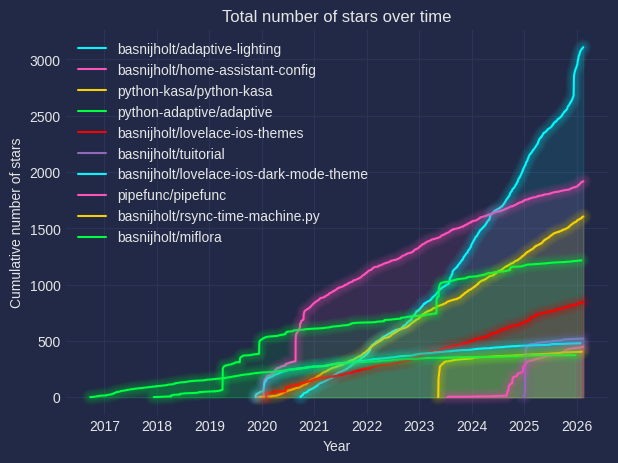

In [5]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")

for star_info in stargazers[:10]:
    dates = star_info["dates"]
    n_stars = list(range(1, len(dates) + 1))
    ax.plot(dates, n_stars, label=star_info["full_name"])
ax.legend()
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time_per_repo.png")

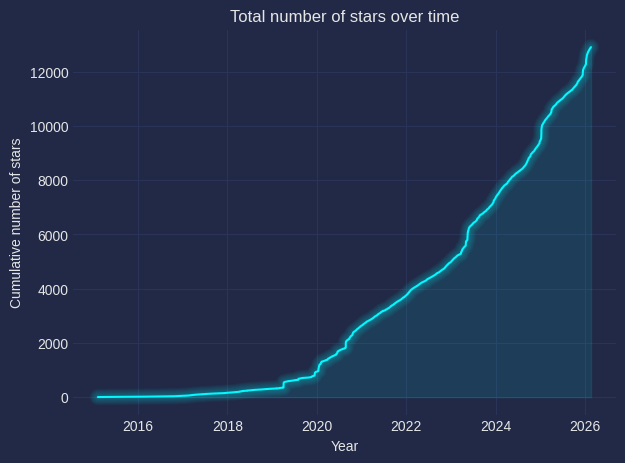

In [6]:
all_dates = sorted([date for star_info in stargazers for date in star_info["dates"]])
n_stars = list(range(1, len(all_dates) + 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(all_dates, n_stars)
ax.set_xlabel("Year")
ax.set_ylabel("Cumulative number of stars")
ax.set_title("Total number of stars over time")
mplcyberpunk.add_glow_effects()
plt.savefig("stars_over_time.png")

In [7]:
# gd.to_plotly_json()

# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# with open("data/traces_data.json", "r") as infile:
#     traces_data = json.load(infile)
# fig = make_subplots()
# for trace_data in traces_data:
#     trace = go.Scatter(**trace_data)
#     fig.add_trace(trace)
# fig.update_layout(
#     title="Cumulative number of stars over time",
#     xaxis_title="Date",
#     yaxis_title="Number of stars",
# )
# fig.show()


## Render template

In [8]:
with open("README.jinja2", "r") as f:
  template = f.read()
txt = jinja2.Template(template).render(
    most_stars_strs_summary=most_stars_strs_summary,
    most_stars_strs_rest=most_stars_strs_rest,
    now=str(datetime.now()),
)
with open("README.md", "w") as f:
    f.write(txt)
print(txt)

# Bas Nijholt 👋

- 👷🏻‍♂️ Currently at [IonQ](https://ionq.com/), doing my bit in building a quantum computer, before that I was at [Microsoft Quantum](https://quantum.microsoft.com/).
- 🌟 A deep dive into computational topological quantum mechanics earned me [my PhD](https://github.com/basnijholt/thesis).
- 🎨 I've crafted [a](https://github.com/basnijholt/adaptive-lighting) [few](https://github.com/basnijholt/aiokef) [libraries](https://github.com/basnijholt/miflora) for Home Assistant, making home automation a bit more fun.
- ⚒️ Made other tools [speed up](https://github.com/python-adaptive/adaptive) and [massively parallelize](https://github.com/basnijholt/adaptive-scheduler) numerical simulations.
- 🏅 Very passionate about open-source, software quality, user experience, and smooth performance.
- 🐍 Python is my go-to language in most of my projects.
- Some of my favorite creations:
  - 📈 **[python-adaptive/adaptive](https://github.com/python-adaptive/adaptive/)**: Parallel active lea